In [1]:
import nbformat
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast

def extract_trials_per_block(nb_path, study_names=None):
    def parse_params(line):
        match = re.match(r"Trial (\d+) with params: (.+)", line)
        if not match:
            return None
        trial_number = int(match.group(1))
        try:
            params = ast.literal_eval(match.group(2))
            params["trial_number"] = trial_number
            return params
        except:
            return None

    def parse_f1(line):
        match = re.match(r".*Trial (\d+) finished with value: ([0-9.]+).*", line)
        if not match:
            return None
        trial_number = int(match.group(1))
        f1_score = float(match.group(2))
        params = extract_params_from_line(line)
        params["trial_number"] = trial_number
        params["f1_score"] = f1_score
        return params

    def extract_params_from_line(line):
        match = re.search(r"\{(.+?)\}", line)
        if not match:
            return {}
        try:
            return ast.literal_eval("{" + match.group(1) + "}")
        except:
            return {}

    with open(nb_path, 'r', encoding='utf-8') as f:
        nb = nbformat.read(f, as_version=4)

    all_lines = []
    for cell in nb.cells:
        if cell.cell_type == "code" and "outputs" in cell:
            for output in cell["outputs"]:
                if output.output_type == "stream":
                    all_lines.extend(output["text"].split("\n"))

    # OPRAVA – správné dělení bloků podle "Trial 0"
    blocks = []
    current_block = []

    for line in all_lines:
        if "Trial 0 with params:" in line:
            if current_block:
                blocks.append(current_block)
            current_block = []
        current_block.append(line.strip())

    if current_block:
        blocks.append(current_block)

    # Zpracování jednotlivých bloků
    all_trials = []
    for i, block in enumerate(blocks):
        block_trials = []
        block_f1s = []
        for line in block:
            if "with params:" in line:
                trial = parse_params(line)
                if trial:
                    trial["study_name"] = (
                        study_names[i-1] if study_names and i <= len(study_names) else f"Study {i}"
                    )
                    trial["f1_score"] = None
                    block_trials.append(trial)
            elif "finished with value:" in line:
                f1 = parse_f1(line)
                if f1:
                    block_f1s.append(f1)

        for trial in block_trials:
            for f1 in block_f1s:
                if (
                    trial["trial_number"] == f1["trial_number"] and
                    abs(trial.get("learning_rate", -1) - f1.get("learning_rate", -2)) < 1e-10 and
                    trial.get("weight_decay") == f1.get("weight_decay") and
                    trial.get("warmup_steps") == f1.get("warmup_steps")
                ):
                    trial["f1_score"] = f1["f1_score"]
                    break
            all_trials.append(trial)

    return pd.DataFrame(all_trials)


In [51]:

df = extract_trials_per_block(
    "../actual/image_based/cifar100_MBN_hp_search_aug.ipynb",
    [1,2,3,4,5,6]
)



In [152]:
# Filter study_name 4 from df and df2
df_destilace = df[df["study_name"] == 6].copy()
df_destilace_aug = df2[df2["study_name"] == 2].copy()

# Rename study_name values
df_destilace["study_name"] = "Destilace"
df_destilace_aug["study_name"] = "Destilace - augmentace"

# Concatenate the two dataframes
df3 = pd.concat([df_destilace, df_destilace_aug], ignore_index=True)
print(df3)

    learning_rate  weight_decay  warmup_steps  trial_number  \
0        0.000281         0.010            24             0   
1        0.000103         0.000            28             1   
2        0.000055         0.010            27             2   
3        0.000116         0.003            17             3   
4        0.000837         0.001             9             4   
..            ...           ...           ...           ...   
92       0.001584         0.006            15            92   
93       0.000217         0.002            31            93   
94       0.000479         0.004            32            94   
95       0.000466         0.001            11            95   
96       0.000054         0.000            26            96   

                study_name  f1_score  lambda_param  temperature  
0   Destilace - augmentace       NaN           0.6          2.5  
1   Destilace - augmentace       NaN           0.6          5.5  
2   Destilace - augmentace       NaN         

In [19]:
df["study_name"].unique()

array([1, 2, 3, 4, 'Study 5', 'Study 6'], dtype=object)

In [52]:
top = df[(df["study_name"]== 1)].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,study_name,f1_score,lambda_param,temperature
125,0.000393,0.003,6,125,1,0.542626,NaN,NaN
133,0.000482,0.000,14,133,1,0.540891,NaN,NaN
71,0.000383,0.001,25,71,1,0.540541,NaN,NaN
33,0.000517,0.009,20,33,1,0.538258,NaN,NaN
95,0.000420,0.010,15,95,1,0.537569,NaN,NaN


In [53]:
top = df[(df["study_name"]== 2)*df["lambda_param"] > 0].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,study_name,f1_score,lambda_param,temperature
223,0.000586,0.004,7,78,2,0.569130,0.6,5.5
281,0.000611,0.003,0,136,2,0.567913,1.0,6.5
220,0.000496,0.005,2,75,2,0.563224,0.6,6.0
196,0.000449,0.002,1,51,2,0.562718,0.9,5.5
205,0.000468,0.010,1,60,2,0.561327,0.3,2.5


In [54]:
top = df[(df["study_name"]== 3)].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,study_name,f1_score,lambda_param,temperature
318,0.001045,0.005,9,23,3,0.556304,NaN,NaN
329,0.001043,0.007,20,34,3,0.556202,NaN,NaN
322,0.001028,0.006,17,27,3,0.556170,NaN,NaN
373,0.001014,0.005,28,78,3,0.555873,NaN,NaN
363,0.000995,0.004,5,68,3,0.555797,NaN,NaN


In [55]:
top = df[(df["study_name"]== 4)*df["lambda_param"] > 0].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,study_name,f1_score,lambda_param,temperature
536,0.001246,0.001,10,91,4,0.550545,0.2,5.0
522,0.001222,0.010,15,77,4,0.550270,0.8,3.0
584,0.001205,0.004,18,139,4,0.550155,0.1,7.0
478,0.001301,0.007,10,33,4,0.550101,0.6,2.0
549,0.001325,0.003,14,104,4,0.550070,0.2,5.0


In [56]:
top = df[(df["study_name"]== 5)].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,study_name,f1_score,lambda_param,temperature
603,0.000408,0.008,6,8,5,0.788522,NaN,NaN
622,0.000340,0.009,6,65,5,0.787436,NaN,NaN
681,0.000376,0.008,17,124,5,0.786964,NaN,NaN
691,0.000322,0.007,16,134,5,0.786050,NaN,NaN
651,0.000403,0.006,19,94,5,0.785305,NaN,NaN


In [57]:
top = df[(df["study_name"]== 6)*df["lambda_param"] > 0].sort_values(by="f1_score", ascending=False).head(5)
top

,learning_rate,weight_decay,warmup_steps,trial_number,study_name,f1_score,lambda_param,temperature
748,0.000545,0.003,10,41,6,0.797654,0.5,6.0
806,0.000607,0.007,13,100,6,0.797076,0.7,6.5
843,0.000583,0.009,9,137,6,0.796864,0.4,7.0
753,0.000406,0.004,0,46,6,0.796790,0.6,4.0
763,0.000452,0.002,0,56,6,0.795738,0.7,6.0


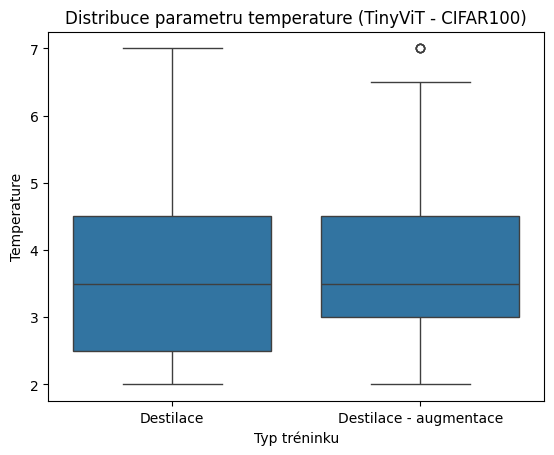

In [6]:
sns.boxplot(data=df[df["study_name"].isin(["Destilace", "Destilace - augmentace"])], x="study_name", y="temperature")
plt.title("Distribuce parametru temperature (TinyViT - CIFAR100)")
plt.ylabel("Temperature")
plt.xlabel("Typ tréninku")
plt.show()

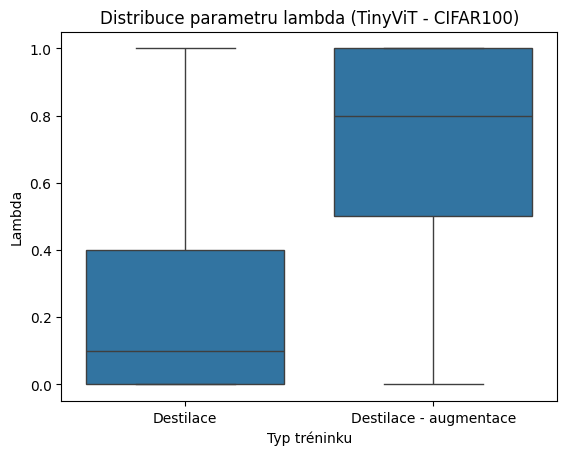

In [7]:
sns.boxplot(data=df[df["study_name"].isin(["Destilace", "Destilace - augmentace"])], x="study_name", y="lambda_param")
plt.title("Distribuce parametru lambda (TinyViT - CIFAR100)")
plt.ylabel("Lambda")
plt.xlabel("Typ tréninku")
plt.show()

In [217]:
df = extract_trials_with_f1(
    "../actual/text_based/trec_fine_BiLSTM_hp_search.ipynb",
    study_names=["Normální trénink", "Destilace", "Normální trénink - augmentace", "Destilace - augmentace"]
)

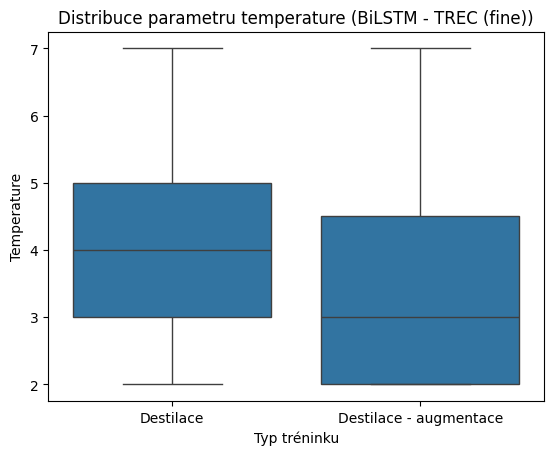

In [218]:
sns.boxplot(data=df[(df["study_name"].isin(["Destilace", "Destilace - augmentace"]))], x="study_name", y="temperature")
plt.title("Distribuce parametru temperature (BiLSTM - TREC (fine))")
plt.ylabel("Temperature")
plt.xlabel("Typ tréninku")
plt.show()

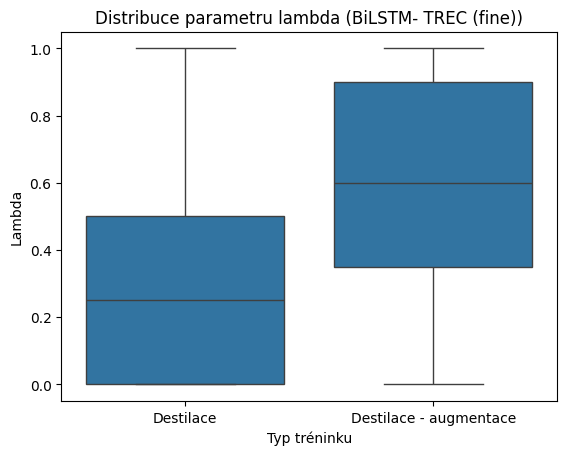

In [219]:
sns.boxplot(data=df[(df["study_name"].isin(["Destilace", "Destilace - augmentace"]))], x="study_name", y="lambda_param")
plt.title("Distribuce parametru lambda (BiLSTM- TREC (fine))")
plt.ylabel("Lambda")
plt.xlabel("Typ tréninku")
plt.show()